## Course Project: Text Classification with Rakuten France Product Data

The project focuses on the topic of large-scale product type code text classification where the goal is to predict each product’s type code as defined in the catalog of Rakuten France. This project is derived from a data challenge proposed by Rakuten Institute of Technology, Paris. Details of the data challenge is [available in this link](https://challengedata.ens.fr/challenges/35).

The above data challenge focuses on multimodal product type code classification using text and image data. **For this project we will work with only text part of the data.**

Please read carefully the description of the challenge provided in the above link. **You can disregard any information related to the image part of the data.**

### To obtain the data
You have to register yourself [in this link](https://challengedata.ens.fr/challenges/35) to get access to the data.

For this project you will only need the text data. Download the training files `x_train` and `y_train`, containing the item texts, and the corresponding product type code labels.

### Pandas for handling the data
The files you obtained are in CSV format. We strongly suggest to use Python Pandas package to load and visualize the data. [Here is a basic tutorial](https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/) on how to handle data in CSV file using Pandas.

If you open the `x_train` dataset using Pandas, you will find that it contains following columns:
1. an integer ID for the product
2. **designation** - The product title
3. description
4. productid
5. imageid

For this project we will only need the integer ID and the designation. You can [`drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) the other columns.

The training output file `y_train.csv` contains the **prdtypecode**, the target/output variable for the classification task, for each integer id in the training input file `X_train.csv`.

### Task for the break
1. Register yourself and download the training and test for text data. You do not need the `supplementary files` for this project.
2. Load the data using pandas and disregard unnecessary columns as mentioned above.
3. On the **designation** column, apply the preprocessing techniques.

### Task for the end of the course
After this preprocessing step, you have now access to a TF-IDF matrix that constitute our data set for the final evaluation project. The project guidelines are:
1. Apply all approaches taught in the course and practiced in lab sessions (Decision Trees, Bagging, Random forests, Boosting, Gradient Boosted Trees, AdaBoost, etc.) on this data set. The goal is to predict the target variable (prdtypecode).
2. Compare performances of all these models in terms of the weighted-f1 scores you can output. 
3. Conclude about the most appropriate approach on this data set for the predictive task. 
4. Write a report in .tex format that adress all these guidelines with a maximal page number of 5 (including figures, tables and references). We will take into account the quality of writing and presentation of the report.

In [1]:
!pip install spacy

In [2]:
!python -m spacy download fr_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


Libraries

In [3]:
import numpy as np
import pandas as pd
import spacy
import fr_core_news_sm

# Choose number of samples tested
import math

# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# dimension reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import SparsePCA

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# pick at random 10% of the total samples
import random 

# classifiers
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

# hyperparameters tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# Load spaCy for french
spacy_nlp = fr_core_news_sm.load()

In [5]:
# download data
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_test = pd.read_csv('X_test.csv')

## Pre-processing

1. We only keep the designation and id. 
2. We normalize the accents, put the text in lower-case, remove the punctuation, tokenise the extracts

In [6]:
# designation and ids
def cleaning(X_train): 
    X_train = X_train.drop(['description', 'productid','imageid'], axis=1)
    X_train.columns = ['integer_id', 'designation']
    return X_train

In [7]:
def normalize_accent(string):
    string = string.replace('á', 'a')
    string = string.replace('â', 'a')

    string = string.replace('é', 'e')
    string = string.replace('è', 'e')
    string = string.replace('ê', 'e')
    string = string.replace('ë', 'e')

    string = string.replace('î', 'i')
    string = string.replace('ï', 'i')

    string = string.replace('ö', 'o')
    string = string.replace('ô', 'o')
    string = string.replace('ò', 'o')
    string = string.replace('ó', 'o')

    string = string.replace('ù', 'u')
    string = string.replace('û', 'u')
    string = string.replace('ü', 'u')

    string = string.replace('ç', 'c')
    
    return string

In [8]:
def raw_to_tokens(raw_string, spacy_nlp):
    # Write code for lower-casing
    string = raw_string.lower()
    
    # Write code to normalize the accents
    string = normalize_accent(string)
        
    # Write code to tokenize
    spacy_tokens = spacy_nlp(string)
        
    # Write code to remove punctuation tokens and create string tokens
    string_tokens = [token.orth_ for token in spacy_tokens if not token.is_punct if not token.is_stop]
    
    # Write code to join the tokens back into a single string
    clean_string = " ".join(string_tokens)
    
    return clean_string

## TF-IDF matrix

Construct the TF-IDF matrix from the pre-processed data. 

In [9]:
X_train = pd.read_csv('X_train_cleaned.csv')
X_test = pd.read_csv('X_test_cleaned.csv')

In [10]:
# create a list from the processed cells
doc_clean_train =  X_train['designation_cleaned'].astype('U').tolist()
doc_clean_test = X_test['designation_cleaned'].astype('U').tolist()

#doc_clean = doc_clean_train + doc_clean_test
doc_clean = doc_clean_train

In [11]:
# convert raw documents into TF-IDF matrix.
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(doc_clean)

print("Shape of the TF-IDF Matrix:")
print(X_tfidf.shape)

Shape of the TF-IDF Matrix:
(84916, 79402)


### Use the TF-IDF matrix as the training set

If applicable, based on the applied transformations:
*   Define the X_train_T matrix as the truncated or TF-IDF matrix
*   Divide back in train and test



In [12]:
# if no transformation is applied i.e. no PCA / truncated SVD: 
X_transformed = X_tfidf
# print(X_transformed)

In [18]:
X_train_T = X_transformed[:84916]
X_test_T = X_transformed[84916:]

print(X_train_T.shape) # 84916
print(X_test_T.shape) # 13812

(84916, 79402)
(0, 79402)


## Apply various models to predict the target variable
1. Decision Trees
2. Bagging
3. Random forests
4. Boosting
5. Gradient Boosted Trees
6. AdaBoost, etc.

### Reduce the dataset to 20% of its initial size for faster training

The selection is done at random i.e. 20% of the training samples are chosen at random within the training set. Assuming the data is uniformly distributed.

In [16]:
row, col = X_train.shape
N = math.ceil(row * 0.2) # 20% of the data
#N = 1000

In [17]:
rdsample = random.sample(range(1, row), N) 

X_train_sample = X_train_T[rdsample,]
Y_train_sample = Y_train.to_numpy()[rdsample,]
Y_train_sample = pd.DataFrame(Y_train_sample[:,1])

print(X_train_sample.shape)
print(Y_train_sample.shape)

(16984, 79402)
(16984, 1)


### 1. Decision trees - Ariel

1.   First parameters tried: { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15), 'splitter':['best', 'random']} - **Optimal:** { 'criterion':['gini'],'max_depth': 14, 'splitter':['best']}
2.   Second parameters tried: { 'criterion':['gini','entropy'],'max_depth': np.arange(13, 30), 'splitter':['best', 'random']} - **Optimal:** { 'criterion':['gini'],'max_depth': 27, 'splitter':['random']}



In [21]:
parameters = {'criterion':['gini','entropy'],'max_depth': np.arange(25, 35), 'splitter':['best', 'random']}
grid_dec_tree = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv = 5, scoring = 'f1_weighted', verbose = 10, n_jobs=-1)
result = grid_dec_tree.fit(X_train_sample, Y_train_sample)

# update verbose to 10 for more steps
# add-in progress bar to evaluate time taken / time it will take
# https://infocenter.informationbuilders.com/wf80/index.jsp?topic=%2Fpubdocs%2FRStat16%2Fsource%2Ftopic47.htm

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.2min finished


In [22]:
# print results from grid search 
result.best_params_
# result.cv_results_

{'criterion': 'entropy', 'max_depth': 34, 'splitter': 'random'}

In [ ]:
table = pd.pivot_table(pd.DataFrame(result.cv_results_),
    values='f1_weighted', index='parameters_max_depth', 
                       columns='parameters_criterion')
     
sns.heatmap(table)

In [77]:
param_range = np.arange(50, 200, 10)
train_scores, test_scores = validation_curve(
                            DecisionTreeClassifier(criterion = 'gini', splitter = 'best'),
                            X = X_train_sample, y = Y_train_sample, scoring = "f1_weighted",
                            param_name = 'max_depth', 
                            param_range = param_range, cv = 3, verbose = 10, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  45 | elapsed:    4.3s remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   6 out of  45 | elapsed:    6.0s remaining:   39.3s
[Parallel(n_jobs=-1)]: Done  11 out of  45 | elapsed:    7.4s remaining:   22.9s
[Parallel(n_jobs=-1)]: Done  16 out of  45 | elapsed:    8.3s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done  21 out of  45 | elapsed:   11.2s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  26 out of  45 | elapsed:   12.7s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  31 out of  45 | elapsed:   14.2s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  36 out of  45 | elapsed:   15.4s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  41 out of  45 | elapsed:   17.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   18.4s finished


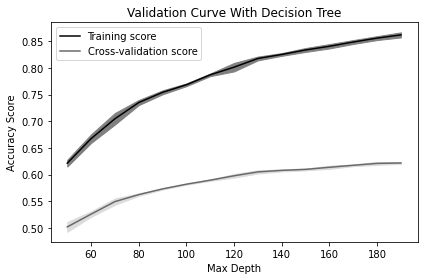

In [78]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [ ]:
dec_tree = DecisionTreeClassifier(result.best_params_)
#result_model = dec_tree.fit(X_train_sample, Y_train_sample)
cross_val_score(dec_tree, X_train_sample, Y_train_sample, cv = 5, score = "f1_weighted")

In [ ]:
# predict on X_test
Y_test = dec_tree.predict(X_test_T)

### 2. Random forests - Camille

In [ ]:
parameters = {
    'bootstrap': [True, False], # whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree
    'max_depth': [None],
    # 'max_features': [None, auto], # "auto" = max_features=sqrt(n_features)
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2],
    'n_estimators': [10]} # flat validation curve - best at 15

rand_forest = GridSearchCV(RandomForestClassifier(), parameters, cv = 5, scoring = 'f1_weighted', verbose=5)
result = rand_forest.fit(X_train_sample, Y_train_sample)

Source : https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [84]:
parameters = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rand_forest = RandomizedSearchCV(RandomForestClassifier(), 
                                 parameters, 
                                 cv = 5, 
                                 scoring = 'f1_weighted', 
                                 verbose = 10, 
                                 n_jobs = -1)

result = rand_forest.fit(X_train_sample, Y_train_sample.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed: 12.0min remaining: 12.0min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed: 15.4min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed: 17.3min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed: 19.3min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 20.4min finished


In [85]:
# print results from grid search 
print(result.best_params_)
print(result.best_score_)

{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
0.6815723183954626


In [86]:
param_range = np.arange(20, 100, 5)
train_scores, test_scores = validation_curve(
                            RandomForestClassifier(bootstrap = True, 
                                                   n_estimators = 1000,
                                                   max_features = "sqrt",
                                                   min_samples_leaf = 2, 
                                                   min_samples_split = 10),
                            X = X_train_sample, y = Y_train_sample, scoring = "f1_weighted",
                            param_name = 'max_depth', 
                            param_range = param_range, cv = 5, verbose = 10, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  80 | elapsed:  2.4min remaining: 18.9min
[Parallel(n_jobs=-1)]: Done  18 out of  80 | elapsed:  3.4min remaining: 11.7min
[Parallel(n_jobs=-1)]: Done  27 out of  80 | elapsed:  4.9min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done  36 out of  80 | elapsed:  6.3min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done  45 out of  80 | elapsed:  7.5min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  54 out of  80 | elapsed:  9.0min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  63 out of  80 | elapsed: 10.3min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  72 out of  80 | elapsed: 11.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 13.0min finished


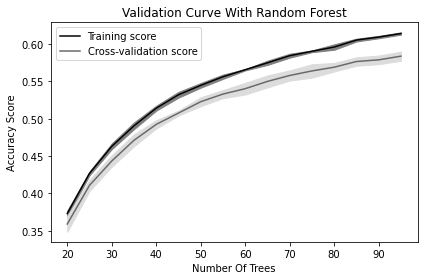

In [87]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [ ]:
# print results from grid search 
result.best_params_
# result.cv_results_

In [ ]:
rand_forest = RandomForestClassifier(result.best_params_)
#result_model = dec_tree.fit(X_train_sample, Y_train_sample)
cross_val_score(rand_forest, X_train_sample, Y_train_sample, cv = 5, score = "f1_weighted")
#dec_tree

### 3. Boosting - Niels

In [17]:
!pip install xgboost

     |████████████████████████████████| 109.7 MB 9.5 kB/s s eta 0:00:01  |█████████████████████▏          | 72.5 MB 4.7 MB/s eta 0:00:08


In [24]:
parameters = {
    'eta': [0.08, 0.1, 0.15], 
    'max_depth': [6, 8, 10, None], 
    'objective': ['multi:softmax'], 
    'num_classes' : [27], 
    'subsample' : [0.8],
    'colsample_bytree' : [0.8],
    'colsample_bylevel' : [1], 
    'tree_method' : ['approx', 'hist', 'gpu_hist'],
    'silent' : [False],
    'min_child_weight' : [1], 
    'max_delta_step' : [0],
    'booster' : ['gbtree']
    } 

model = RandomizedSearchCV(xgb.XGBClassifier(), 
                           parameters, 
                           cv = 3, 
                           scoring = 'f1_weighted', 
                           verbose = 10, 
                           n_jobs = -1, 
                           n_iter = 20)

result = model.fit(X_train_sample, Y_train_sample.values.ravel())

print(result.best_params_)
print(result.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done  36 out of  60 | elapsed: 24.0min remaining: 16.0min
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  43 out of  60 | elapsed: 26.2min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed: 32.4min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed: 36.6min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 37.3min finished


{'tree_method': 'approx', 'subsample': 0.8, 'silent': False, 'objective': 'multi:softmax', 'num_classes': 27, 'min_child_weight': 1, 'max_depth': 10, 'max_delta_step': 0, 'eta': 0.15, 'colsample_bytree': 0.8, 'colsample_bylevel': 1, 'booster': 'gbtree'}
0.7001171536738044


In [19]:
print(result.best_params_)
print(result.best_score_)

{'subsample': 0.8, 'silent': False, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'multi:softmax', 'num_classes': 27, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 0, 'gamma': 0, 'eta': 0.1, 'colsample_bytree': 0.8, 'colsample_bylevel': 1, 'booster': 'gbtree'}
0.6641018615665804


In [27]:
parameters = {
    'eta': [0.05, 0.1, 0.2, 0.3], 
    'max_depth': [6, 8, 10, 12],  
    'objective': ['multi:softmax'], 
    'num_classes' : [27], 
    'subsample' : [0.8],
    'colsample_bytree' : [0.8]} 

model = RandomizedSearchCV(xgb.XGBClassifier(), parameters, cv = 3, scoring = 'f1_weighted', verbose = 10, n_jobs = -1) # , n_jobs = -1
result = model.fit(X_train_sample, Y_train_sample.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
Pickling array (shape=(149091,), dtype=int32).
Pickling array (shape=(16985,), dtype=int32).
Memmapping (shape=(149091,), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_2172_855603339/2172-139989702571664-a5201802d7bf4a4ab6440af1f8fb0dd5.pkl
Pickling array (shape=(16984,), dtype=int64).
Pickling array (shape=(11322,), dtype=int64).
Pickling array (shape=(5662,), dtype=int64).
Pickling array (shape=(149091,), dtype=int32).
Pickling array (shape=(16985,), dtype=int32).
Memmapping (shape=(149091,), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_2172_855603339/2172-139989702571664-a5201802d7bf4a4ab6440af1f8fb0dd5.pkl
Pickling array (shape=(16984,), dtype=int64).
Pickling array (shape=(11323,), dtype=int64).
Pickling array (shape=(5661,), dtype=int64).
Pickling array (shape=(149091,), dtype=int32).
Pickling array (shape=(16985,

In [28]:
# print results from grid search 

print(result.best_params_)
print(result.best_score_)
#print(grad_boost.cv_results_)

{'subsample': 0.8, 'objective': 'multi:softmax', 'num_classes': 27, 'max_depth': 8, 'eta': 0.2, 'colsample_bytree': 0.8}
0.6949316403731332


In [25]:
param_range = np.arange(2, 14, 2)
train_scores, test_scores = validation_curve(
                            xgb.XGBClassifier(eta = 0.1, objective = 'multi:softmax', num_classes = 27),
                            X = X_train_sample, y = Y_train_sample.values.ravel(), scoring = "f1_weighted", 
                            param_name = 'max_depth', 
                            param_range = param_range, cv = 3)

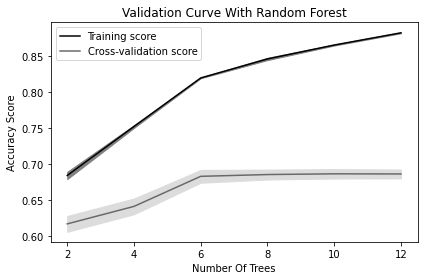

In [26]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [25]:
# print results from grid search 
result.best_params_
# result.cv_results_

{'eta': 0.01, 'max_depth': 3, 'num_class': 5, 'objective': 'multi:softmax'}

### 4. Gradient Boosted Trees - Camille

In [28]:
parameters = {
    "max_depth": [30, 50],
    "n_estimators": [10, 20, 30],
    "learning_rate": [0.05, 0.1, 0.2]
}

grad_boost = RandomizedSearchCV(GradientBoostingClassifier(), parameters, cv = 3, scoring = 'f1_weighted', verbose = 10, n_jobs = -1)
result = grad_boost.fit(X_train_sample, Y_train_sample)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(148907,), dtype=int32).
Pickling array (shape=(16985,), dtype=int32).
Memmapping (shape=(148907,), dtype=float64) to new file C:\Users\arimo\AppData\Local\Temp\joblib_memmapping_folder_23008_204497212\23008-2547443953168-f9268a42d16e4ba4a9d77d5294fa8ad4.pkl
Pickling array (shape=(1, 16984), dtype=int64).
Pickling array (shape=(11322,), dtype=int32).
Pickling array (shape=(5662,), dtype=int32).
Pickling array (shape=(148907,), dtype=int32).
Pickling array (shape=(16985,), dtype=int32).
Memmapping (shape=(148907,), dtype=float64) to old file C:\Users\arimo\AppData\Local\Temp\joblib_memmapping_folder_23008_204497212\23008-2547443953168-f9268a42d16e4ba4a9d77d5294fa8ad4.pkl
Pickling array (shape=(1, 16984), dtype=int64).
Pickling array (shape=(11323,), dtype=int32).
Pickling array (shape=(5661,), dtype=int32).
Pickling array (shape=(

C:\Users\arimo\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
# print results from grid search 

print(result.best_params_)
print(result.best_score_)
#print(grad_boost.cv_results_)

{'n_estimators': 30, 'max_depth': 50, 'learning_rate': 0.1}
0.6769346662011252


### 5. Bagging - Niels

In [32]:
values, counts = np.unique(Y_train['prdtypecode'], return_counts=True)
print(values)
print(counts)

[  10   40   50   60 1140 1160 1180 1280 1281 1300 1301 1302 1320 1560
 1920 1940 2060 2220 2280 2403 2462 2522 2582 2583 2585 2705 2905]
[ 3116  2508  1681   832  2671  3953   764  4870  2070  5045   807  2491
  3241  5073  4303   803  4993   824  4760  4774  1421  4989  2589 10209
  2496  2761   872]


In [38]:
dict(zip(values, (counts/sum(counts))))

{10: 0.03669508690941636,
 40: 0.029535069951481464,
 50: 0.0197960337274483,
 60: 0.009797917942437232,
 1140: 0.031454613971454146,
 1160: 0.04655188657025767,
 1180: 0.008997126572141882,
 1280: 0.057350793725564085,
 1281: 0.02437703141928494,
 1300: 0.05941165386970653,
 1301: 0.009503509350416883,
 1302: 0.029334872108907627,
 1320: 0.03816712986951811,
 1560: 0.05974139149276932,
 1920: 0.05067360685854256,
 1940: 0.009456403975693627,
 2060: 0.058799283998304204,
 2220: 0.00970370719299072,
 2280: 0.05605539592067455,
 2403: 0.05622026473220595,
 2462: 0.016734184370436667,
 2522: 0.05875217862358095,
 2582: 0.030488953789627397,
 2583: 0.12022469263742994,
 2585: 0.029393753827311696,
 2705: 0.0325144849027274,
 2905: 0.010268971689669792}

In [61]:
parameters = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [10, 20, 30], 
              "max_samples" : [0.7, 0.8, 1]
             }

DTC = DecisionTreeClassifier(random_state = 11, 
                             max_features = 0.8,
                             max_depth = 6)

BC = BaggingClassifier(base_estimator = DTC)

bagging = RandomizedSearchCV(BC, 
                             parameters, 
                             random_state = 11, 
                             cv = 5, 
                             scoring = 'f1_weighted', 
                             verbose = 10,
                             n_jobs = -1)

result = bagging.fit(X_train_sample, Y_train_sample.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   33.6s remaining:   33.6s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   40.0s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:   41.4s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:   45.0s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.9s finished


In [62]:
# print results from grid search 

print(result.best_params_)
print(result.best_score_)

{'n_estimators': 30, 'max_samples': 0.8, 'base_estimator__splitter': 'random', 'base_estimator__criterion': 'entropy'}
0.2828390468266617


In [58]:
parameters = {"max_samples" : [0.7, 0.8, 1],
              "base_estimator__bootstrap": [True, False], 
              "base_estimator__n_estimators": [10, 20, 30], 
              "base_estimator__max_depth" : [6, 8, 10],
              "base_estimator__min_samples_leaf" : [1, 2],
              "base_estimator__min_samples_split": [2],
             }

bagging = RandomizedSearchCV(BaggingClassifier(base_estimator = RandomForestClassifier()), 
                             parameters, 
                             random_state = 11, 
                             cv = 5, 
                             scoring = 'f1_weighted', 
                             verbose = 10,
                             n_jobs = -1)

result = bagging.fit(X_train_sample, Y_train_sample.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    6.7s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:    8.9s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:    9.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    9.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.2s finished


In [59]:
# print results from grid search 

print(result.best_params_)
print(result.best_score_)

{'max_samples': 0.7, 'base_estimator__n_estimators': 10, 'base_estimator__min_samples_split': 2, 'base_estimator__min_samples_leaf': 1, 'base_estimator__max_depth': 10, 'base_estimator__bootstrap': False}
0.2087871794256951


### 6. AdaBoost - Ariel

In [18]:
parameters = {"n_estimators" : [20, 30], 
              "learning_rate" : [0.05, 0.1]}

DTC = DecisionTreeClassifier(random_state = 11, 
                             max_features = "auto", 
                             class_weight = "balanced", 
                             max_depth = 100)

RFC = RandomForestClassifier(criterion = 'gini', 
                             n_estimators = 2000, 
                             min_samples_split = 10, 
                             min_samples_leaf = 2, 
                             max_features = 'sqrt', 
                             max_samples = 0.8,
                             max_depth = 100, 
                             bootstrap = True)

ABC = AdaBoostClassifier(base_estimator = RFC)

adaboost = GridSearchCV(ABC, 
                        parameters, 
                        cv = 3, 
                        scoring = 'f1_weighted', 
                        verbose = 20, 
                        n_jobs = -1)

result = adaboost.fit(X_train_sample, Y_train_sample)

NameError: name 'DecisionTreeClassifier' is not defined

In [96]:
# print results from grid search 
print(result.best_params_)
print(result.best_score_)

{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
0.6815723183954626


After this preprocessing step, you have now access to a TF-IDF matrix that constitute our data set for the final evaluation project. The project guidelines are:
1. Apply all approaches taught in the course and practiced in lab sessions () on this data set. The goal is to predict the target variable (prdtypecode).
2. Compare performances of all these models in terms of the weighted-f1 scores you can output. 
3. Conclude about the most appropriate approach on this data set for the predictive task. 
4. Write a report in .tex format that adress all these guidelines with a maximal page number of 5 (including figures, tables and references). We will take into account the quality of writing and presentation of the report.

IDEAS: For the test set maybe recreate a TF-IDF based on train + test 

In [ ]:
def plot_results(model, param = 'min_samples_leaf', name = 'min_samples_leaf'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = result.cv_results_['mean_test_score']
    test_scores = result.cv_results_['mean_test_score']
    train_time = result.cv_results_['mean_test_score']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    plt.tight_layout(pad = 4)

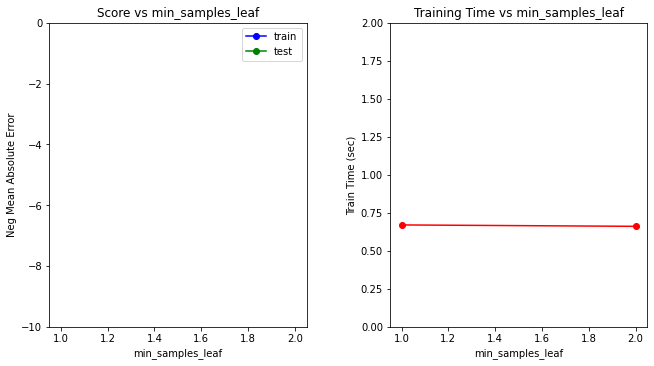

In [ ]:
plot_results(rand_forest)